In [901]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Conv1D, Flatten, MaxPooling1D, RepeatVector, \
    TimeDistributed, LayerNormalization, Dropout, MultiHeadAttention, Input
from tensorflow.keras.optimizers import Adam
import statsmodels.api as sm
from pmdarima import auto_arima
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [902]:
import tensorflow as tf

In [900]:
tf.random.set_seed(7)

KeyboardInterrupt: 

In [903]:
def read_data(path, dim_type, gold_data=None, fed_rate=None, use_percentage=1):
    '''
    读取数据(详细说明)
    '''
    df = pd.read_csv(path)
    data_len = df.shape[0]
    data = None
    if dim_type!='Multi':
        data = df[dim_type].values.reshape((data_len, 1))
    else:
        # Multi
        df["date"]=pd.to_datetime(df["date"], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d %H:%M:%S')
        #df['CO'] = df['Close'] - df['Open']
        #diff_data = df['CO'].values.reshape((data_len, 1))
        open_data = df["open"].values.reshape((data_len, 1))
        high_data = df["high"].values.reshape((data_len, 1))
        low_data = df["low"].values.reshape((data_len, 1))
        close_data = df["close"].values.reshape((data_len, 1))
        volume_data = df["volume"].values.reshape((data_len, 1))
        if gold_data is not None:
            gold_data['Date']=gold_data['Date'].dt.strftime('%Y-%m-%d')
            df['Gold']=df['Date']
            
            # calc the gold series
            df['Gold'] = df['Gold'].apply(lambda x: gold_data['Close'][x==gold_data['Date']].values[0] if x in gold_data['Date'].values else np.nan)  
            # fillna using interpolating
            df['Gold'] = df['Gold'].interpolate(limit_direction="both")

            gold_data_fill=df["Gold"].values.reshape((data_len, 1))
            if fed_rate is not None:
                fed_rate['DATE']=fed_rate['DATE'].dt.strftime('%Y-%m-%d')
                df['fed']=df['Date']
                
                # calc the gold series
                df['fed'] = df['fed'].apply(lambda x: fed_rate['FEDFUNDS'][x==fed_rate['DATE']].values[0] if x in fed_rate['DATE'].values else np.nan)  
                # fillna using interpolating
                df['fed'] = df['fed'].interpolate(limit_direction="both")
    
                fed_data=df["fed"].values.reshape((data_len, 1))
                data = np.hstack((close_data, open_data, high_data, low_data, volume_data, gold_data_fill, fed_data))
            else:
                data = np.hstack((close_data, open_data, high_data, low_data, volume_data, gold_data_fill))
        else:
            data = np.hstack((close_data, open_data, high_data, low_data, volume_data))
    return data[0:int(np.floor(data_len * use_percentage))], np.floor(data_len * use_percentage)


In [904]:
def split_sequence(sequence, dim_type, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of the input pattern
        end_ix = i + n_steps_in
        # find the end of the output pattern
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequence):
            break
        if dim_type == 'Multi':
            # gather input and output parts of the pattern
            seq_x = sequence[i:end_ix, 1:]
            seq_y = sequence[end_ix:out_end_ix, 0]
        else:
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def data_trasform(data, anti=False, scaler=None):
    '''
    说明以及例子
    MinMax data and anti MinMax data
    :param data: the data source
    :param model: MinMax and anti MinMax
    :param scaler: anti MinMax scaler
    :return: the transformed data

    '''
    if not anti:
        # 归一化
        # 创建一个空字典来存储每一列的 scaler
        scalers = {}
        # 归一化数据的容器
        normalized_data = np.zeros_like(data)
        # 循环每一列
        for i in range(data.shape[1]):  # data.shape[1] 是列的数量
            # 为每一列创建一个新的 MinMaxScaler
            scaler = MinMaxScaler()
            # 将列数据调整为正确的形状，即(-1, 1)
            column_data = data[:, i].reshape(-1, 1)
            # 拟合并转换数据
            normalized_column = scaler.fit_transform(column_data)
            # 将归一化的数据存回容器中
            normalized_data[:, i] = normalized_column.ravel()
            # 存储scaler以便后续使用
            scalers[i] = scaler
        # 现在 normalized_data 是完全归一化的数据
        # scalers 字典包含每一列的 MinMaxScaler 实例
        return normalized_data, scalers
    else:
        # 反归一化
        # 如果data是三维数组，去除最后一个维度
        if data.ndim == 3 and data.shape[2] == 1:
            data = data.squeeze(axis=2)

        restored_data = np.zeros_like(data)
        for i in range(data.shape[1]):  # 遍历所有列
            column_data = data[:, i].reshape(-1, 1)
            restored_data[:, i] = scaler.inverse_transform(column_data).ravel()
        return restored_data

def create_transformer_model(input_seq_length, output_seq_length, num_features, d_model, num_heads, ff_dim,
                             num_transformer_blocks, dropout_rate=0.1):
    inputs = Input(shape=(input_seq_length, num_features))

    x = Dense(d_model)(inputs)

    for _ in range(num_transformer_blocks):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)  # Dropout after attention
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ff_output = Dense(ff_dim, activation="relu")(x)
        ff_output = Dropout(dropout_rate)(ff_output)  # Dropout after first dense layer
        ff_output = Dense(d_model)(ff_output)

        x = LayerNormalization(epsilon=1e-6)(x + ff_output)

    outputs = Dense(output_seq_length)(x[:, -1, :])  # We take the last step's output for forecasting
    model = Model(inputs, outputs)
    return model

def create_model(model_type, n_features, n_steps_in, n_steps_out):
    '''
        create model
        :param model_type:  LSTM,BD LSTM(bidirectional LSTM),ED LSTM(Encoder-Decoder LSTM),CNN
        :param n_features:
        :param n_steps_in:
        :param n_steps_out:
        :return: the created model
    '''
    model = Sequential()
    adam_optimizer = Adam(learning_rate=0.001)
    if model_type == 'LSTM':
        # LSTM
        model.add(LSTM(100, activation='sigmoid', return_sequences=True, input_shape=(n_steps_in, n_features)))
        model.add(LSTM(100, activation='sigmoid'))
        model.add(Dense(n_steps_out))

    elif model_type == 'BD LSTM':
        # bidirectional LSTM
        model.add(Bidirectional(LSTM(50, activation='sigmoid'), input_shape=(n_steps_in, n_features)))
        model.add(Dense(n_steps_out))

    elif model_type == 'ED LSTM':
        # Encoder-Decoder LSTM
        # Encoder
        model.add(LSTM(100, activation='sigmoid', input_shape=(n_steps_in, n_features)))
        # Connector
        model.add(RepeatVector(n_steps_out))
        # Decoder
        model.add(LSTM(100, activation='sigmoid', return_sequences=True))
        model.add(TimeDistributed(Dense(1)))

    elif model_type == 'CNN':
        # CNN
        model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(20, activation='relu'))
        model.add(Dense(n_steps_out))

    elif model_type == 'Convolutional LSTM':
        # Convolutional LSTM
        model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
        model.add(LSTM(20, activation='relu', return_sequences=False))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(n_steps_out))

    elif model_type == 'Transformer':
        model = create_transformer_model(n_steps_in, n_steps_out, n_features, d_model=64,
                                         num_heads=12, ff_dim=64, num_transformer_blocks=3)

    elif model_type == 'MLP':
        # 多层感知机 (MLP)
        model.add(Dense(20, activation='relu', input_shape=(n_steps_in, n_features)))
        model.add(Flatten())
        model.add(Dense(20, activation='relu'))
        model.add(Dense(n_steps_out))

    elif model_type == 'ARIMA':
        if n_features != 1:
            print("ARIMA model only supports univariate time series data")
            print("ARIMA model has no parameter n_steps_in")
            return None
        model = 'ARIMA'
        return model
    
    else:
        print("no model")
    model.compile(optimizer=adam_optimizer, loss='mse')
    return model


def train_and_forecast(model, n_features, dim_type, data_X, data_Y, n_steps_in, n_steps_out, ech):
    # 训练模型
    # 隐藏输出
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

    X, y = split_sequence(data_X, dim_type, n_steps_in, n_steps_out)
    # 对于多维数据，调整最后一个维度为特征数
    X = X.reshape((X.shape[0], X.shape[1], n_features))

#######################################################################################
    if model == 'ARIMA':
        # 检查数据是否平稳
        fig = plt.figure(figsize=(12, 8))
        ax1 = fig.add_subplot(211)
        fig = sm.graphics.tsa.plot_acf(data_X.squeeze(), lags=40, ax=ax1)
        ax2 = fig.add_subplot(212)
        fig = sm.graphics.tsa.plot_pacf(data_X, lags=40, ax=ax2)
        
        # # 自动确定 ARIMA 模型的参数
        # auto_model = auto_arima(data_X, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
        # # 输出最佳 ARIMA 模型的参数
        # print(auto_model.summary())
        
        # 使用最佳参数拟合 ARIMA 模型
        # ARIMA 模型只接受单变量时间序列，这里假设 data_X 和 data_Y 是一维数组
        # order = auto_model.order
        order = (6,1,6)
        arma_model = ARIMA(data_X, order=order)
        model_fit = arma_model.fit()
        # 拟合结果
        fit_result = model_fit.fittedvalues
        # 使用模型进行滚动预测
        history = list(data_X)
        test_result = []
        for t in range(len(data_Y)):
            model = ARIMA(history, order=order)
            model_fit = model.fit()
            output = model_fit.forecast(n_steps_out)
            test_result.append(output)
            history.append(data_Y[t])  # 更新历史数据
        test_result = np.array(test_result)
        fit_result = fit_result.reshape(len(fit_result), 1)
        return fit_result, test_result
#######################################################################################

    # 训练模型
    model.fit(X, y, epochs=ech, batch_size=32, verbose=1)

    # 拟合结果
    fit_result = []
    for index, ele in enumerate(X):
        print(f'Fitting {index}th data')
        pred = model.predict(ele.reshape((1, n_steps_in, n_features)))
        fit_result.append(pred)
    fr = np.array(fit_result)
    fit_result = fr.reshape(len(fit_result), n_steps_out)
    # 测试结果
    test_x, test_y = split_sequence(data_Y, dim_type, n_steps_in, n_steps_out)
    test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], n_features))
    test_result = []
    for index, ele in enumerate(test_x):
        print(f'Predicting {index}th data')
        pred = model.predict(ele.reshape((1, n_steps_in, n_features)))
        test_result.append(pred)
    tr = np.array(test_result)
    test_result = tr.reshape(len(test_result), n_steps_out)

    # 恢复输出
    sys.stdout = sys.__stdout__
    sys.stderr = sys.__stderr__
    return fit_result, test_result

def eval_result(result, n_steps_out, target, mode):
    '''
    evaluate the modl resule
    :param result:the model result
    :param n_steps_out:the days you predict
    :param target:the ground-true
    :param mode:the type of evaluation(you can choose 0：rmse,1：mape)
    :return:the evaluation result
    '''
    if mode==0:
        # return rmse result
        # 归一化
        result, _ = data_trasform(result)
        target, _ = data_trasform(target)
        # 下面需要修改
        rmse = []
        for i in range(n_steps_out):
            rmse.append(np.sqrt(np.mean((result[:, i] - target[:, i]) ** 2)))
        return rmse

    elif mode==1:
        # return MAPE result
        result = result + 0.0000001
        target = target + 0.0000001
        mape = []
        for i in range(n_steps_out):
            mape.append(np.mean(np.abs((target[:, i] - result[:, i]) / target[:, i])) * 100)
        return mape
    else:
        return None

In [7]:
# add the prediction column to the test_dataset
def update_prediction(test_dataset, test_result, n_steps_in):
    updateted_dataset = test_dataset[n_steps_in:]
    test_result_list = test_result.tolist()
    t_list = list()
    for i in range(len(test_result_list)):
        number = test_result_list[i][0]
        t_list.append(number)
    updateted_dataset['prediction'] = t_list 
    return updateted_dataset

In [8]:
df = pd.read_csv('~\.qlib\csv_data\crypto_data_60\BTC.csv')
df_btc = df[['date', 'symbol', 'open', 'high', 'low', 'close', 'volume']]

In [9]:
df_btc

,date,symbol,open,high,low,close,volume
0,2017-08-17 04:00:00,BTC,4261.48,4313.62,4261.32,4308.83,47.181009
1,2017-08-17 05:00:00,BTC,4308.83,4328.69,4291.37,4315.32,23.234916
2,2017-08-17 06:00:00,BTC,4330.29,4345.45,4309.37,4324.35,7.229691
3,2017-08-17 07:00:00,BTC,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 08:00:00,BTC,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...,...,...
60662,2024-07-24 02:00:00,BTC,65666.01,65928.01,65476.84,65878.16,672.373340
60663,2024-07-24 03:00:00,BTC,65878.16,66111.50,65784.53,66052.71,601.260330
60664,2024-07-24 04:00:00,BTC,66052.71,66072.01,65791.42,65860.00,571.421180
60665,2024-07-24 05:00:00,BTC,65860.01,65914.49,65610.00,65814.01,673.836710


In [10]:
path = '~\.qlib\csv_data\crypto_data_60\BTC.csv'
gold_data = None 
fed_rate = None 
dim_type = 'Multi'
use_percentage = 1

n_steps_in = 24  # take prior 24 values as input 
n_steps_out = 12 # predict t+12 value 

percentage = 0.7  # 训练集百分比
epochs = 25  # 迭代次数
#rounds = 3  # Number of exp

In [11]:
data, data_len = read_data(path, dim_type, gold_data, fed_rate, use_percentage)
data, scalers = data_trasform(data)

# split into train and test
train_set = data[0:int(np.floor(data_len * percentage))]  # 训练集
test_set = data[int(np.floor(data_len * percentage)):]  # 测试集

In [12]:
train_set

array([[1.96697206e-02, 1.96669469e-02, 1.92528273e-02, 2.05164511e-02,
        3.43866888e-04],
       [1.97615710e-02, 2.03366171e-02, 1.94655993e-02, 2.09433090e-02,
        1.69341827e-04],
       [1.98893691e-02, 2.06401255e-02, 1.97022322e-02, 2.11989976e-02,
        5.26917800e-05],
       ...,
       [2.58534766e-01, 2.60086032e-01, 2.58644444e-01, 2.59925901e-01,
        1.56155952e-02],
       [2.59907003e-01, 2.59039168e-01, 2.59210329e-01, 2.60882177e-01,
        8.63887652e-03],
       [2.61578851e-01, 2.60410472e-01, 2.60846852e-01, 2.61652652e-01,
        1.02422107e-02]])

In [13]:
test_bit_data = df_btc[int(np.floor(data_len * percentage)):]

In [14]:
n_features = len(train_set[0]) - 1 if len(train_set[0]) > 1 else 1 # features of the input 

In [15]:
model_type =['LSTM', 'BD LSTM', 'CNN', 'MLP', 'ED LSTM', 'Convolutional LSTM']

In [16]:
model_use = model_type[5]
Model = create_model(model_use, n_features, n_steps_in, n_steps_out)

train_result, test_result = train_and_forecast(Model, n_features, dim_type, train_set, test_set, n_steps_in,
                                                n_steps_out, epochs)

# ----------------------evaluation--------------------
train_result = data_trasform(train_result, True, scalers[0])  # 反归一化
test_result = data_trasform(test_result, True, scalers[0])  # 反归一化

test_result_list = test_result.tolist()
t_list = list()
for j in range(len(test_result_list)):
    number = test_result_list[j][0]
    t_list.append(number)
#update_dataset_model[pred_name[i]] = t_list

In [27]:
len(test_result_list)

18172

In [20]:
len(update_dataset_model)

18177

In [310]:
len(t_list)

18172

In [28]:
t_list_6 = list()
for j in range(len(test_result_list)):
    number = test_result_list[j][5]
    t_list_6.append(number)

In [320]:
t_list_5 = list()
for j in range(len(test_result_list)):
    number = test_result_list[j][4]
    t_list_5.append(number)

In [321]:
t_list_4 = list()
for j in range(len(test_result_list)):
    number = test_result_list[j][3]
    t_list_4.append(number)

In [322]:
t_list_3 = list()
for j in range(len(test_result_list)):
    number = test_result_list[j][2]
    t_list_3.append(number)

In [323]:
t_list_2 = list()
for j in range(len(test_result_list)):
    number = test_result_list[j][1]
    t_list_2.append(number)

In [32]:
len(t_list_6)

18172

In [24]:
t_list[18176]

65632.203125

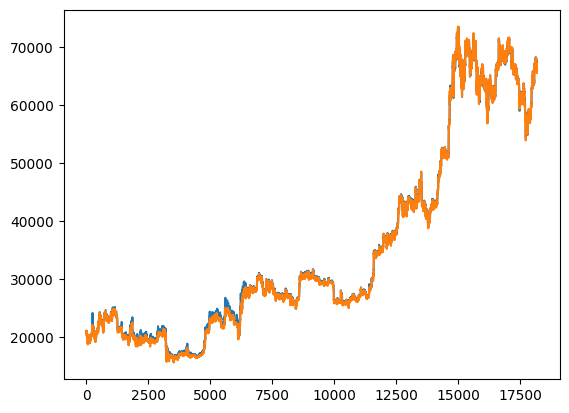

In [31]:
plt.plot(t_list_6)
plt.plot(update_dataset_model['close'].tolist())

In [24]:
len(update_dataset_model['close'].tolist())

18177

In [25]:
len(t_list)

18172

In [34]:
test_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [44]:
end_ix = 1 + 12

In [47]:
out_end = end_ix + 3

In [46]:
test_list[1:end_ix]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [48]:
test_list[end_ix:out_end]

[13, 14, 15]

In [64]:
update_dataset_model['ELSTM'] = t_list

In [65]:
update_dataset_model 

,date,symbol,open,high,low,close,volume,ELSTM
42490,2022-06-27 21:00:00,BTC,20913.57,20916.90,20783.15,20803.24,1093.61442,20968.130859
42491,2022-06-27 22:00:00,BTC,20803.25,20950.00,20762.80,20814.42,2552.76729,20896.166016
42492,2022-06-27 23:00:00,BTC,20814.42,20887.99,20680.00,20742.56,1915.17870,20891.267578
42493,2022-06-28 00:00:00,BTC,20742.57,20873.82,20684.00,20770.50,2620.37096,20839.988281
42494,2022-06-28 01:00:00,BTC,20770.50,20814.70,20553.04,20619.45,2874.79364,20833.630859
...,...,...,...,...,...,...,...,...
60662,2024-07-24 02:00:00,BTC,65666.01,65928.01,65476.84,65878.16,672.37334,65714.914062
60663,2024-07-24 03:00:00,BTC,65878.16,66111.50,65784.53,66052.71,601.26033,65575.546875
60664,2024-07-24 04:00:00,BTC,66052.71,66072.01,65791.42,65860.00,571.42118,65911.062500
60665,2024-07-24 05:00:00,BTC,65860.01,65914.49,65610.00,65814.01,673.83671,65712.007812


In [43]:
import pandas_ta as ta

In [53]:
help(ta.ema)

In [58]:
close_sma_10 = ta.sma(update_dataset_model['close'])

In [59]:
update_dataset_model = update_dataset_model.join(close_sma_10)

In [61]:
update_dataset_model = update_dataset_model.dropna()

In [91]:
update_dataset_model 

,date,symbol,open,high,low,close,volume,SMA_24
42513,2022-06-28 20:00:00,BTC,20255.01,20321.92,20202.01,20277.57,1982.02776,20761.345000
42514,2022-06-28 21:00:00,BTC,20277.58,20397.47,20274.31,20393.44,1198.43183,20744.270000
42515,2022-06-28 22:00:00,BTC,20393.43,20463.20,20268.05,20308.02,2040.49278,20723.170000
42516,2022-06-28 23:00:00,BTC,20308.01,20367.41,20210.00,20281.29,2507.04424,20703.950417
42517,2022-06-29 00:00:00,BTC,20281.28,20388.79,20152.00,20289.83,3027.28428,20683.922500
...,...,...,...,...,...,...,...,...
60662,2024-07-24 02:00:00,BTC,65666.01,65928.01,65476.84,65878.16,672.37334,66324.967500
60663,2024-07-24 03:00:00,BTC,65878.16,66111.50,65784.53,66052.71,601.26033,66265.747500
60664,2024-07-24 04:00:00,BTC,66052.71,66072.01,65791.42,65860.00,571.42118,66220.914167
60665,2024-07-24 05:00:00,BTC,65860.01,65914.49,65610.00,65814.01,673.83671,66195.331250


# Test Run starts here

In [878]:
update_dataset_model = test_bit_data[n_steps_in:]

In [879]:
len(update_dataset_model)

18177

In [880]:
update_dataset_model = update_dataset_model[:18172]

In [881]:
len(update_dataset_model)

18172

In [882]:
update_dataset_model['CLSTM'] = t_list_6

In [883]:
update_dataset_model = update_dataset_model.join(ta.rma(update_dataset_model['close'], length=36))

In [884]:
update_dataset_model = update_dataset_model.dropna()

In [885]:
update_dataset_model['diff'] = update_dataset_model['CLSTM'] - update_dataset_model['RMA_36']

In [886]:
update_dataset_model

,date,symbol,open,high,low,close,volume,CLSTM,EMA_36,diff
42525,2022-06-29 08:00:00,BTC,20093.74,20149.00,19961.81,19990.38,2410.37206,20134.835938,20584.696389,-449.860451
42526,2022-06-29 09:00:00,BTC,19990.38,20233.98,19971.01,20063.27,3598.30508,20152.990234,20556.511179,-403.520944
42527,2022-06-29 10:00:00,BTC,20063.26,20147.12,20025.00,20097.00,3038.00098,20170.015625,20531.672737,-361.657112
42528,2022-06-29 11:00:00,BTC,20097.00,20122.43,19854.92,20104.80,4656.69536,20159.449219,20508.598535,-349.149316
42529,2022-06-29 12:00:00,BTC,20104.81,20189.13,19977.18,20014.12,4072.63617,20112.402344,20481.869965,-369.467621
...,...,...,...,...,...,...,...,...,...,...
60657,2024-07-23 21:00:00,BTC,65836.00,66049.99,65782.00,65872.00,579.43470,65615.203125,66716.905185,-1101.702060
60658,2024-07-23 22:00:00,BTC,65872.00,66043.47,65790.00,65917.99,678.72040,65838.664062,66673.720580,-835.056518
60659,2024-07-23 23:00:00,BTC,65917.99,66054.00,65793.01,65936.01,673.09371,65794.515625,66633.844333,-839.328708
60660,2024-07-24 00:00:00,BTC,65936.00,66146.01,65780.00,65784.70,522.47964,65828.046875,66587.944639,-759.897764


In [887]:
diff_lstm = update_dataset_model['diff'].tolist()

In [888]:
signal = []
for i in range(len(diff_lstm)):
    if i == 0:
        signal.append(0)
    elif diff_lstm[i] > 0 and diff_lstm[i-1] < 0:
        signal.append(1)
    elif diff_lstm[i] < 0 and diff_lstm[i-1] > 0:
        signal.append(-1)
    else:
        signal.append(0)

In [889]:
update_dataset_model['signal'] = signal

In [890]:
decision_price = []
for index, row in update_dataset_model.iterrows():
    if row['signal'] == 1:
        decision_price.append(row['close'])
    elif row['signal'] == -1:
        decision_price.append(-1*row['close'])

In [891]:
len(decision_price)

1206

In [893]:
decision_price_long = decision_price

In [894]:
len(decision_price_long)

1206

In [895]:
pct_return_list = []
init_money = 10000
for i in list(range(0, len(decision_price_long), 2)):
    pct_ret = ((init_money / decision_price_long[i]) * (-1 * decision_price_long[i+1]) - init_money)  / init_money
    pct_return_list.append(pct_ret)

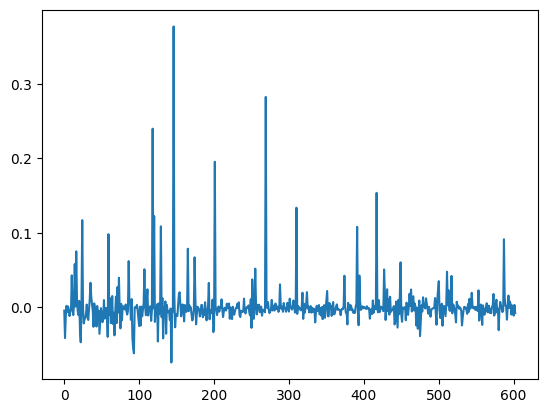

In [896]:
plt.plot(pct_return_list)

In [897]:
output_return = cumulative_sum(pct_return_list)

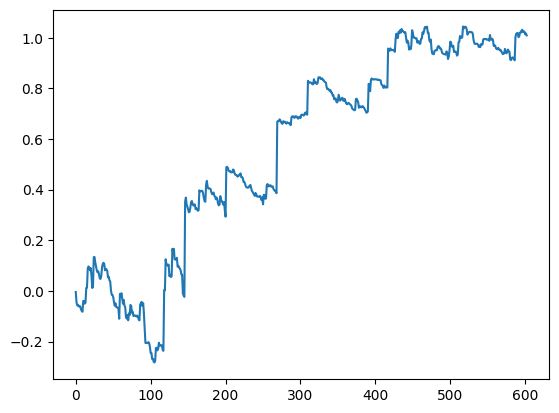

In [898]:
plt.plot(output_return)

In [59]:
def cumulative_sum(input_list):
    # Convert the list to a NumPy array
    input_array = np.array(input_list)
    # Compute the cumulative sum along the first axis of the array
    cumulative_sum_array = np.cumsum(input_array)
    # Convert the NumPy array back to a list and return it
    return cumulative_sum_array.tolist()

In [63]:
update_dataset_model['diff_close'] = update_dataset_model['close'] - update_dataset_model['SMA_24']

In [64]:
diff_close = update_dataset_model['diff_close'].tolist()

In [65]:
signal_close = []
for i in range(len(diff_close)):
    if i == 0:
        signal_close.append(0)
    elif diff_close[i] > 0 and diff_close[i-1] < 0:
        signal_close.append(1)
    elif diff_close[i] < 0 and diff_close[i-1] > 0:
        signal_close.append(-1)
    else:
        signal_close.append(0)

In [66]:
update_dataset_model['signal_close'] = signal_close

In [67]:
decision_price_close = []
for index, row in update_dataset_model.iterrows():
    if row['signal_close'] == 1:
        decision_price_close.append(row['close'])
    elif row['signal_close'] == -1:
        decision_price_close.append(-1*row['close'])

In [68]:
len(decision_price_close)

2062

In [70]:
pct_return_list_close = []
init_money = 10000
for i in list(range(0, len(decision_price_close), 2)):
    pct_ret = ((init_money / decision_price_close[i]) * (-1 * decision_price_close[i+1]) - init_money)  / init_money
    pct_return_list_close.append(pct_ret)

In [75]:
decisoin_price_short_close = decision_price_close[1:2061]

In [77]:
len(decisoin_price_short_close)

2060

In [79]:
pct_return_short_list_close = []
for i in list(range(0, len(decisoin_price_short_close), 2)):
    pct_ret = ((-1*decisoin_price_short_close[i]) - decisoin_price_short_close[i+1]) / decisoin_price_short_close[i]
    pct_return_short_list_close.append(pct_ret)

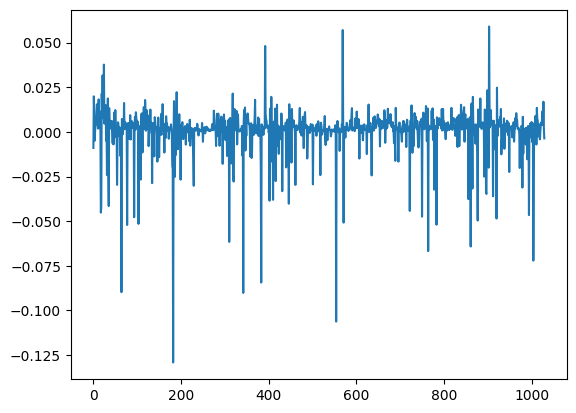

In [80]:
plt.plot(pct_return_short_list_close)

In [71]:
output_return_close = cumulative_sum(pct_return_list_close)

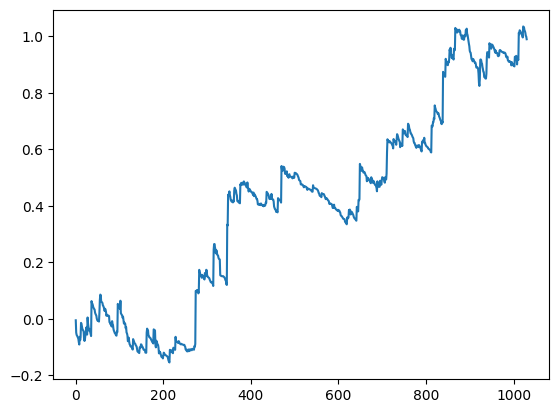

In [72]:
plt.plot(output_return_close)

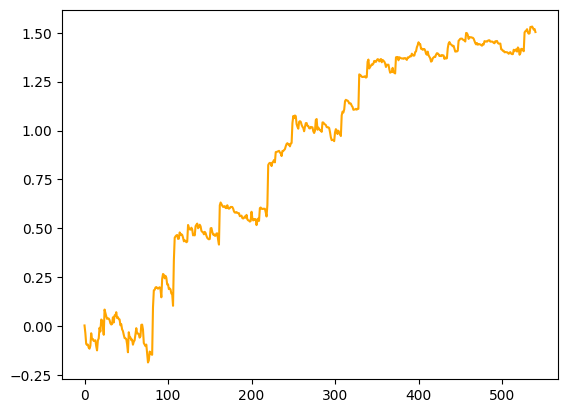

In [74]:
plt.plot(output_return, 'orange') #24 #6

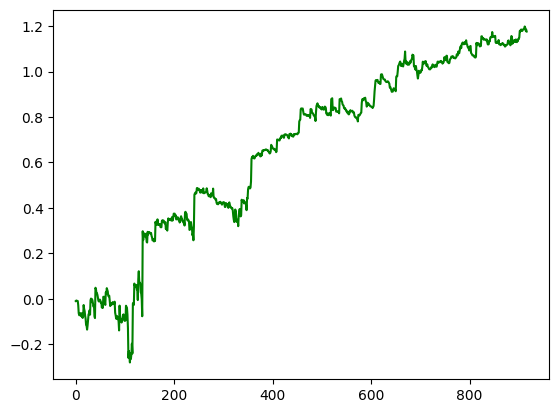

In [264]:
plt.plot(output_return, 'green') #12, 5

In [89]:
update_dataset_model['daily_return'] = (update_dataset_model['open'] - update_dataset_model['close']) / update_dataset_model['open'] 

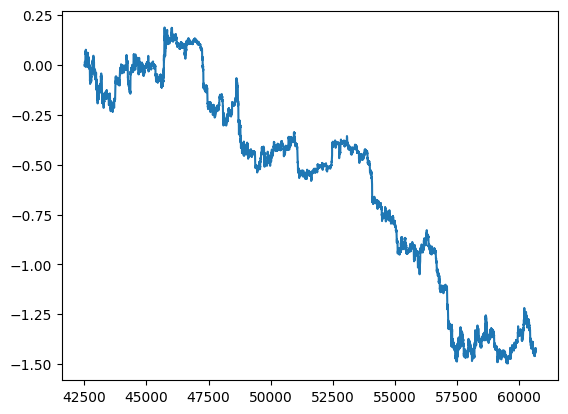

In [94]:
plt.plot(update_dataset_model['daily_return'].cumsum())

In [539]:
update_dataset_model = test_bit_data[n_steps_in:]

In [540]:
update_dataset_model = update_dataset_model[:18172]

In [541]:
update_dataset_model['CLSTM'] = t_list_6

In [542]:
update_dataset_model

,date,symbol,open,high,low,close,volume,CLSTM
42490,2022-06-27 21:00:00,BTC,20913.57,20916.90,20783.15,20803.24,1093.61442,20985.042969
42491,2022-06-27 22:00:00,BTC,20803.25,20950.00,20762.80,20814.42,2552.76729,20961.603516
42492,2022-06-27 23:00:00,BTC,20814.42,20887.99,20680.00,20742.56,1915.17870,20943.753906
42493,2022-06-28 00:00:00,BTC,20742.57,20873.82,20684.00,20770.50,2620.37096,20893.675781
42494,2022-06-28 01:00:00,BTC,20770.50,20814.70,20553.04,20619.45,2874.79364,20882.132812
...,...,...,...,...,...,...,...,...
60657,2024-07-23 21:00:00,BTC,65836.00,66049.99,65782.00,65872.00,579.43470,65709.421875
60658,2024-07-23 22:00:00,BTC,65872.00,66043.47,65790.00,65917.99,678.72040,65969.937500
60659,2024-07-23 23:00:00,BTC,65917.99,66054.00,65793.01,65936.01,673.09371,65893.937500
60660,2024-07-24 00:00:00,BTC,65936.00,66146.01,65780.00,65784.70,522.47964,65938.562500


In [543]:
update_dataset_model = update_dataset_model.join(ta.wma(update_dataset_model['CLSTM'], length=48))

In [544]:
update_dataset_model = update_dataset_model.join(ta.wma(update_dataset_model['CLSTM'], length=12))

In [545]:
update_dataset_model

,date,symbol,open,high,low,close,volume,CLSTM,WMA_48,WMA_12
42490,2022-06-27 21:00:00,BTC,20913.57,20916.90,20783.15,20803.24,1093.61442,20985.042969,NaN,NaN
42491,2022-06-27 22:00:00,BTC,20803.25,20950.00,20762.80,20814.42,2552.76729,20961.603516,NaN,NaN
42492,2022-06-27 23:00:00,BTC,20814.42,20887.99,20680.00,20742.56,1915.17870,20943.753906,NaN,NaN
42493,2022-06-28 00:00:00,BTC,20742.57,20873.82,20684.00,20770.50,2620.37096,20893.675781,NaN,NaN
42494,2022-06-28 01:00:00,BTC,20770.50,20814.70,20553.04,20619.45,2874.79364,20882.132812,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
60657,2024-07-23 21:00:00,BTC,65836.00,66049.99,65782.00,65872.00,579.43470,65709.421875,66871.913817,66155.357572
60658,2024-07-23 22:00:00,BTC,65872.00,66043.47,65790.00,65917.99,678.72040,65969.937500,66822.836701,66095.379808
60659,2024-07-23 23:00:00,BTC,65917.99,66054.00,65793.01,65936.01,673.09371,65893.937500,66772.182657,66036.258914
60660,2024-07-24 00:00:00,BTC,65936.00,66146.01,65780.00,65784.70,522.47964,65938.562500,66725.274580,65996.317608


In [546]:
update_dataset_model = update_dataset_model.dropna()

In [548]:
update_dataset_model['diff'] = update_dataset_model['WMA_12'] - update_dataset_model['WMA_48']

In [549]:
diff_lstm = update_dataset_model['diff'].tolist()

In [550]:
signal = []
for i in range(len(diff_lstm)):
    if i == 0:
        signal.append(0)
    elif diff_lstm[i] > 0 and diff_lstm[i-1] < 0:
        signal.append(1)
    elif diff_lstm[i] < 0 and diff_lstm[i-1] > 0:
        signal.append(-1)
    else:
        signal.append(0)

In [551]:
update_dataset_model['signal'] = signal

In [552]:
decision_price = []
for index, row in update_dataset_model.iterrows():
    if row['signal'] == 1:
        decision_price.append(row['close'])
    elif row['signal'] == -1:
        decision_price.append(-1*row['close'])

In [553]:
len(decision_price)

682

In [554]:
decision_price

[19409.23,
 -19450.24,
 19299.99,
 -19147.25,
 19712.8,
 -19552.4,
 20435.25,
 -21554.52,
 19574.57,
 -20606.76,
 21289.51,
 -21018.99,
 22245.93,
 -22777.2,
 23448.78,
 -22684.83,
 22521.8,
 -21894.8,
 21292.31,
 -23793.25,
 24490.53,
 -23794.81,
 23100.92,
 -22776.69,
 23402.83,
 -23123.82,
 23151.46,
 -22889.24,
 23161.02,
 -23263.92,
 24002.48,
 -23906.32,
 24485.12,
 -24284.07,
 24817.62,
 -24049.48,
 23786.42,
 -23671.55,
 21379.57,
 -21248.71,
 21350.98,
 -21317.85,
 21618.45,
 -21558.13,
 20781.08,
 -20644.47,
 20262.28,
 -19947.2,
 20258.09,
 -20050.02,
 20125.29,
 -19954.41,
 19882.69,
 -19744.01,
 19826.49,
 -19796.84,
 19771.81,
 -18978.6,
 19292.84,
 -20764.12,
 19839.7,
 -19635.8,
 19603.17,
 -18875.8,
 19235.21,
 -18744.02,
 18903.67,
 -18674.45,
 19082.72,
 -19080.2,
 19555.58,
 -19359.71,
 19197.36,
 -19591.51,
 19993.09,
 -19423.84,
 19091.24,
 -19232.66,
 19335.92,
 -20193.31,
 20101.01,
 -20047.04,
 19504.7,
 -19277.72,
 19115.62,
 -19089.16,
 18432.14,
 -18415.0,
 

In [555]:
decision_price_long = decision_price

In [556]:
pct_return_list = []
init_money = 10000
for i in list(range(0, len(decision_price_long), 2)):
    pct_ret = ((init_money / decision_price_long[i]) * (-1 * decision_price_long[i+1]) - init_money)  / init_money
    pct_return_list.append(pct_ret)

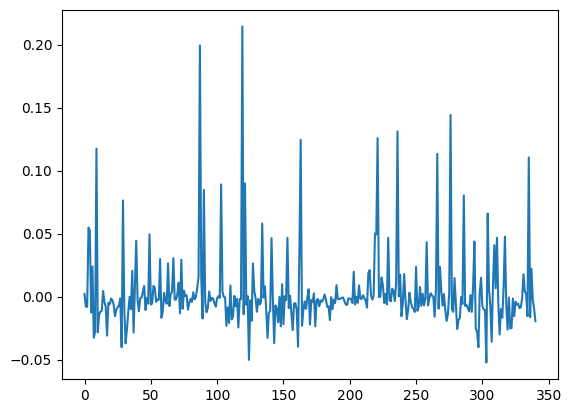

In [557]:
plt.plot(pct_return_list)

In [558]:
output_return = cumulative_sum(pct_return_list)

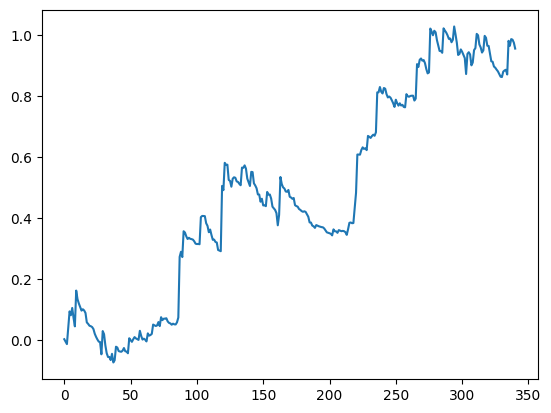

In [559]:
plt.plot(output_return)